# Odometry based on RANSAC matching of USIP keypoints

Odometry evaluation is performed on KITTI dataset

USIP (learnable keypoints detector) parameters:
* Num of keypoints per pcd : 64
* Non-maximum suppression distance : 2 meters

As keypoints descriptor FPFH (Fast Point Feature Histogram) was used

In [1]:
import open3d as o3d
import numpy as np
import os

## Open-loop odometry on KITTI dataset

In [2]:
# Hyper-parameters
NORMAL_RADIUS = 1
NORMAL_NN = 100
FEATURE_RADIUS = 10
FEATURE_NN = 500
DISTANCE_THRESHOLD = 1

In [3]:
# Returns numpy presentation of point cloud
def get_point_cloud(path):
    pcd_np = None
    if path.endswith('npy'):
        pcd_np = np.load(path)[:, :3]
    elif path.endswith('bin'):
        pcd_np = np.fromfile(path, dtype=np.float32).reshape(-1, 3)
    else:
        raise Exception('Point cloud format is not supported')
    
    return pcd_np


# Returns open3d point cloud representation
def get_pcd_from_numpy(np_pcd, color=[0, 0, 1]):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_pcd)
    pcd.paint_uniform_color(color)
    return pcd


In [4]:
# Since keypoints is not always the same points as in point cloud, they are added
# to the whole point cloud to calculate features
def get_keypoints_features(np_pcd, np_keypoints):
    np_combined = np.concatenate((np_pcd, np_keypoints))

    pcd_combined = get_pcd_from_numpy(np_combined)
    pcd_combined.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=NORMAL_RADIUS, max_nn=NORMAL_NN))

    pcd_fpfh = o3d.registration.compute_fpfh_feature(pcd_combined
                    , o3d.geometry.KDTreeSearchParamHybrid(radius=FEATURE_RADIUS, max_nn=FEATURE_NN))
    
    pcd_fpfh.data = pcd_fpfh.data[:, -np_keypoints.shape[0]:]
    return pcd_fpfh

In [5]:
def get_transformation(np_pcd, np_keypoints, np_pcd_2, np_keypoints_2):
    keypoints_features = get_keypoints_features(np_pcd, np_keypoints)
    keypoints_features_2 = get_keypoints_features(np_pcd_2, np_keypoints_2)

    distance_threshold = DISTANCE_THRESHOLD

    result = o3d.registration.registration_ransac_based_on_feature_matching(
            get_pcd_from_numpy(np_keypoints), get_pcd_from_numpy(np_keypoints_2)
            , keypoints_features, keypoints_features_2, distance_threshold,
            o3d.registration.TransformationEstimationPointToPoint(False), 4, [
                o3d.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
                o3d.registration.CorrespondenceCheckerBasedOnDistance(
                    distance_threshold)
            ], o3d.registration.RANSACConvergenceCriteria(1000000, 100))


    return result.transformation, np.asarray(result.correspondence_set).shape[0]

### Ground trouth odometry reading and vizualization

In [6]:
import csv

kitti_odometry_path = '../data_odometry_poses_KITTI/dataset/poses/00.txt'
odometry = []
with open(kitti_odometry_path, newline='') as csvfile:
    odometry_reader = csv.reader(csvfile, delimiter=' ')
    for row in odometry_reader:
        row = [float(i) for i in row]
        odometry.append(np.array(row).reshape(3, 4))

In [7]:
path_x = []
path_y = []
for matrix in odometry:
    path_x.append(float(matrix[0, 3]))
    path_y.append(float(matrix[2, 3]))

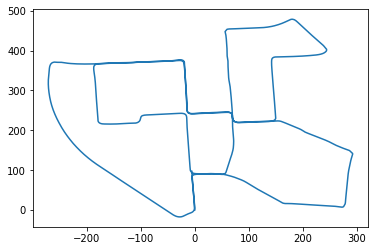

In [8]:
import matplotlib.pyplot as plt

plt.plot(path_x, path_y)
plt.show()

### Odometry estimation

3 40 000032 000041
000032,000041,0.99991,0.00119,-0.01305,-0.07124,-0.00124,0.99999,-0.00444,-0.15867,0.01305,0.00446,0.99990,8.87657,0.00000,0.00000,0.00000,1.00000



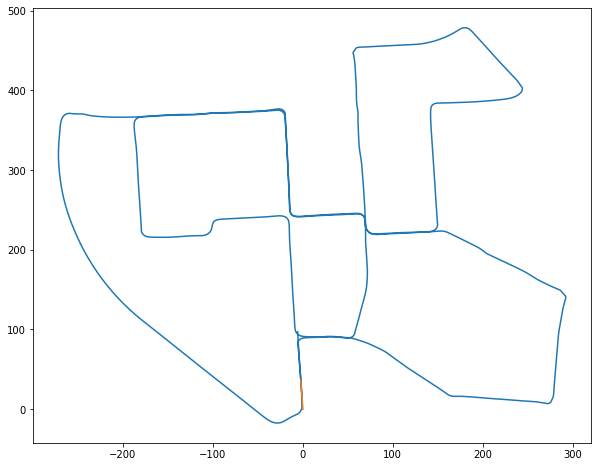

KeyboardInterrupt: 

In [9]:
from IPython.display import clear_output

kitti_keypoints_path = '../keypoints_kitti_2_64/00/'
kitti_pcds_path = '../all_kitti/numpy/00/np_0.20_20480_r90_sn/'

keypoint_files = os.listdir(kitti_keypoints_path)
keypoint_files.sort()

global_transform = np.eye(4)

pred_path_x = [0]
pred_path_y = [0]

trans = []

idx = keypoint_files[0].split('.')[0]
pcds = [ get_pcd_from_numpy(get_point_cloud(kitti_pcds_path + idx + '.npy')) ]

NORMAL_RADIUS = 1
NORMAL_NN = 100
FEATURE_RADIUS = 5
FEATURE_NN = 500
DISTANCE_THRESHOLD = 0.2


file = open('00.csv', 'w') 
for i, filename in enumerate(keypoint_files[:-1]):
    idx = filename.split('.')[0]
    np_pcd_ = get_point_cloud(kitti_pcds_path + idx + '.npy')
    np_keypoints_ = get_point_cloud(kitti_keypoints_path + idx + '.bin')
    
    
    idx_next = keypoint_files[i + 1].split('.')[0]
    np_pcd_2_ = get_point_cloud(kitti_pcds_path + idx_next + '.npy')
    np_keypoints_2_ = get_point_cloud(kitti_keypoints_path + idx_next + '.bin')
    
    transform, corr_num = get_transformation(np_pcd_2_, np_keypoints_2_, np_pcd_, np_keypoints_)
        
    if corr_num < 20:
        FEATURE_NN = 2000
        DISTANCE_THRESHOLD = 1
        
        transform, corr_num = get_transformation(np_pcd_2_, np_keypoints_2_, np_pcd_, np_keypoints_)
        
        if corr_num < 20:
            FEATURE_NN = 3500
            FEATURE_RADIUS = 7
            DISTANCE_THRESHOLD = 1.5
            
            transform, corr_num = get_transformation(np_pcd_2_, np_keypoints_2_, np_pcd_, np_keypoints_)

            if corr_num < 20:
                o3d.visualization.draw_geometries([get_pcd_from_numpy(np_pcd_, [0, 1, 0]).transform(transform)
                                               , get_pcd_from_numpy(np_pcd_2_, [1, 0, 0])])

                o3d.visualization.draw_geometries([get_pcd_from_numpy(np_pcd_, [0, 1, 0])
                                               , get_pcd_from_numpy(np_keypoints_, [1, 0, 0])])

                o3d.visualization.draw_geometries([get_pcd_from_numpy(np_keypoints_, [0, 1, 0]).transform(transform)
                                               , get_pcd_from_numpy(np_keypoints_2_, [1, 0, 0])])
    
    FEATURE_NN = 500
    FEATURE_RADIUS = 5
    DISTANCE_THRESHOLD = 0.2
    
    
    global_transform = global_transform @ transform
    csv_str = idx + ',' + idx_next + ',' + ','.join(['%.5f' % num for num in transform.reshape(16)]) + '\n'
    file.write(csv_str)
    pred_path_x.append(global_transform[0, 3])
    pred_path_y.append(global_transform[2, 3])
    
    trans.append(global_transform)
    
    pcds.append(get_pcd_from_numpy(np_pcd_2_).transform(global_transform))
    
    clear_output(wait=True)
    print(i, corr_num, idx, idx_next)
    print(csv_str)
    plt.figure(figsize=(10, 8))
    plt.plot(path_x, path_y)
    plt.plot(pred_path_x, pred_path_y)
    plt.show()
    
file.close()

### Crash test

Keeps point cloud pairs that have problems with matching (usually crossroads).

In [ ]:
# Hyper-parameters
NORMAL_RADIUS = 1
NORMAL_NN = 100
FEATURE_RADIUS = 10
FEATURE_NN = 5000
DISTANCE_THRESHOLD = 1

In [ ]:
idxes = ['000102', '000168', '000181', '000220', '000397', '000415', '000486'
         , '000609', '000716', '000737', '000934', '001259', '001285', '001381']
idxes_next = ['000128', '000181', '000198', '000236', '000415', '000438', '000498'
              , '000620', '000737', '000757', '000953', '001285', '001300', '001418']

kitti_keypoints_path = 'kitti_keypoints_nms_512/00/'
kitti_pcds_path = 'kitti_pcds/00/'

for i, idx in enumerate(idxes):
    np_pcd_ = get_point_cloud(kitti_pcds_path + idx + '.npy')
    np_keypoints_ = get_point_cloud(kitti_keypoints_path + idx + '.bin')

    idx_next = idxes_next[i]
    np_pcd_2_ = get_point_cloud(kitti_pcds_path + idx_next + '.npy')
    np_keypoints_2_ = get_point_cloud(kitti_keypoints_path + idx_next + '.bin')

    transform, corr_num = get_transformation(np_pcd_2_, np_keypoints_2_, np_pcd_, np_keypoints_)
    print(idx, idx_next, corr_num)

    o3d.visualization.draw_geometries([get_pcd_from_numpy(np_pcd_, [0, 1, 0]).transform(transform)
                                       , get_pcd_from_numpy(np_pcd_2_, [1, 0, 0])])
#     o3d.visualization.draw_geometries([get_pcd_from_numpy(np_pcd_, [0, 1, 0])
#                                        , get_pcd_from_numpy(np_keypoints_, [1, 0, 0])])
#     o3d.visualization.draw_geometries([get_pcd_from_numpy(np_pcd_2_, [0, 1, 0])
#                                        , get_pcd_from_numpy(np_keypoints_2_, [1, 0, 0])])

    o3d.visualization.draw_geometries([get_pcd_from_numpy(np_keypoints_, [0, 1, 0])
                                       , get_pcd_from_numpy(np_keypoints_2_, [1, 0, 0])])